In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib widget
# %matplotlib inline

DATAFILE = "data/Asynchron_data_in.dat"
df = pd.read_csv(DATAFILE, sep=" ")
t = df["time"].to_numpy()
y = df[["position", "acceleration"]].to_numpy()
u = np.zeros(len(y))

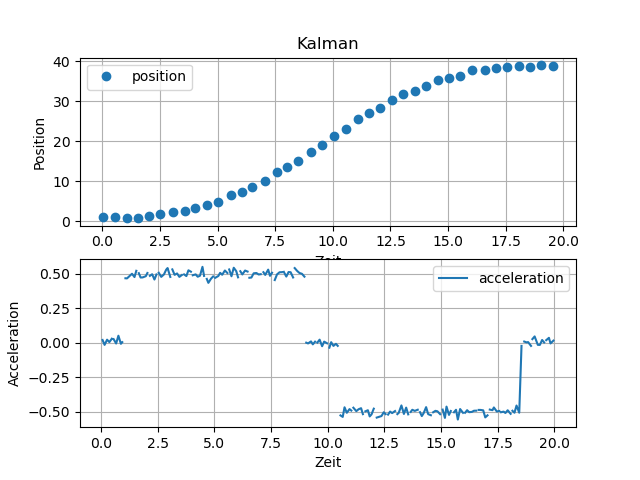

In [90]:
plt.figure()
plt.subplot(2, 1, 1)
plt.title("Kalman")
plt.xlabel("Zeit")
plt.ylabel("Position")
plt.grid(True)
plt.plot(t, df["position"], "o", label="position")
# plt.plot(t, s, label="prediction")
plt.legend()

plt.subplot(2, 1, 2)
# plt.plot(t, v, label="variation")
plt.plot(t, df["acceleration"], "-", label="acceleration")
plt.xlabel("Zeit")
plt.ylabel("Acceleration")
plt.grid(True)
plt.legend()
plt.show()


In [91]:
# Define system matrices
Bd = np.array(
    [
        [0],
        [0],
        [0],
    ]
)
C_s = np.array([1, 0, 0])
C_a = np.array([0, 0, 1])
D = np.array([0])

y_s = y[:, 0]
y_a = y[:, 1]

# Initialization
x_dach = np.array([[y_s[0]], [0], [0]])  # estimate
# P_dach = 30 * np.eye(Bd.size)
P_tilde = 50 * np.eye(Bd.size)
x_tilde = np.array([[y_s[~np.isnan(y_s)][0]], [0], [0]]) # take first non-nan value from y_s array

s = np.zeros(len(y))  # prediction output array
v = np.zeros(len(y))  # variation
a = np.zeros(len(y))
d_y = np.zeros(len(y))  # new error
y_dach = np.zeros(len(y))  # error

P_tilde0 = np.zeros(len(y))
P_tilde1 = np.zeros(len(y))
P_tilde2 = np.zeros(len(y))
P_tilde3 = np.zeros(len(y))
P_tilde4 = np.zeros(len(y))
P_tilde5 = np.zeros(len(y))
P_tilde6 = np.zeros(len(y))
P_tilde7 = np.zeros(len(y))
P_tilde8 = np.zeros(len(y))

### Calculate R and Q based on input plot above
- Take position values from range 0 to 2
- Take acceleration values in stable range from 2 to 8

In [92]:
stable_s = y_s[t < 2]
stable_a = y_a[(t > 2) & (t < 8)] # stable range from ~2 to ~8 see plot above
R_s = stable_s[~np.isnan(stable_s)].var() # discard nan values
R_a = stable_a[~np.isnan(stable_a)].var() # --"--
Q = [0.005]
print(f"{R_s=:g}, {R_a=:g}")
print(f"{Q[0]=:g}")

R_s=0.00547517, R_a=0.000527947
Q[0]=0.005


In [93]:
for i, (s_i, a_i) in enumerate(y[:-1]):
    # print(f"{s_i=:g}, {a_i=:g}")
    Ts = t[i + 1] - t[i]
    Ad = np.array(
        [
            [1, Ts, 0.5 * Ts**2],
            [0, 1, Ts],
            [0, 0, 1],
        ]
    )
    Gd = np.array(
        [
            [0.5 * Ts**2],
            [Ts],
            [1],
        ]
    )

    if np.isnan(s_i):
        C = C_a
        R = R_a
        ym = a_i
    else:
        C = C_s
        R = R_s
        ym = s_i

    x_dach = Ad @ x_tilde + Bd * u[i]
    P_dach = Ad @ P_tilde @ Ad.T + Gd @ Q * Gd.T

    y_dach[i] = (
        C @ x_dach + D * u[i]
    )  # korrigierter Wert ermittelt aus vorherigen Werten
    d_y[i] = ym - y_dach[i]  # aktuellen (neuen) Fehler bestimmen

    k = C @ P_dach @ C.reshape(-1, 1) + R
    if k.ndim >= 2:
        K = (
            P_dach @ C.reshape(-1, 1) @ np.linalg.pinv(k)
        )  # penrose inverse works with k dimension greater 2
    else:
        K = P_dach @ C.reshape(-1, 1) / k  # use plain inverse otherwise

    x_tilde = x_dach + K * d_y[i]
    P_tilde = (np.eye(Bd.size) - K * C) @ P_dach

    s[i], v[i], a[i] = x_tilde

    P_tilde0 = P_tilde[0][0]
    P_tilde1 = P_tilde[0][1]
    P_tilde2 = P_tilde[0][2]
    P_tilde3 = P_tilde[1][0]
    P_tilde4 = P_tilde[1][1]
    P_tilde5 = P_tilde[1][2]
    P_tilde6 = P_tilde[2][0]
    P_tilde7 = P_tilde[2][1]
    P_tilde8 = P_tilde[2][2]

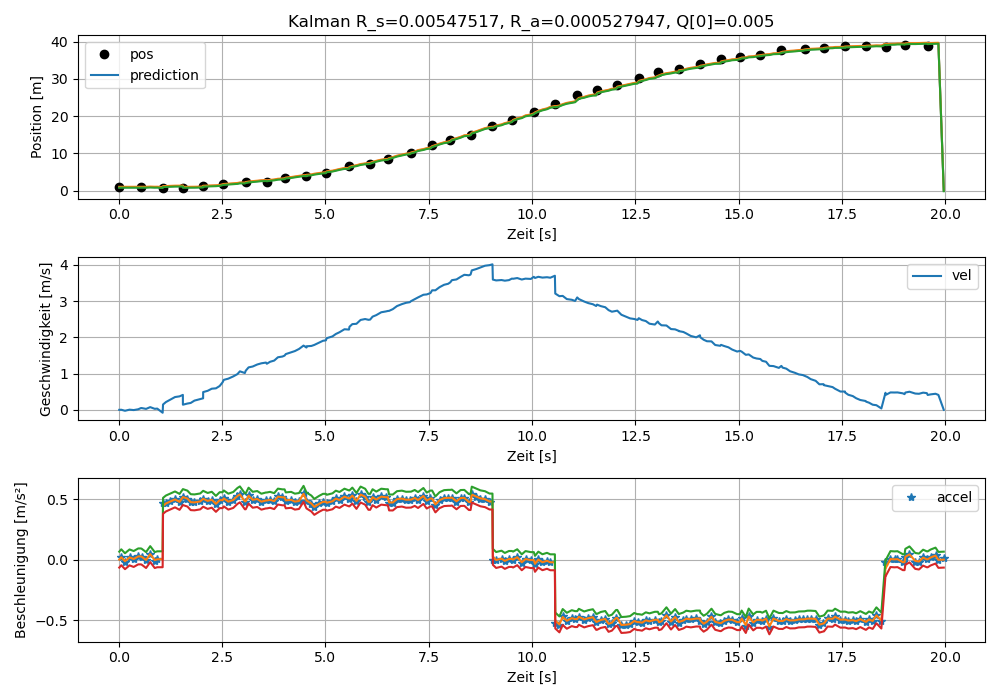

In [94]:
plt.figure(figsize=(10, 7))
plt.subplot(3, 1, 1)
plt.title(f"Kalman {R_s=:g}, {R_a=:g}, {Q[0]=:g}")
plt.xlabel("Zeit")
plt.grid(True)
plt.plot(t, y_s, "ko", label="pos")
plt.plot(t, s, "-", label="prediction")
plt.plot(t, s + 3 * np.sqrt(P_tilde0), "-")
plt.plot(t, s - 3 * np.sqrt(P_tilde0), "-")
plt.xlabel("Zeit [s]")
plt.ylabel("Position [m]")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, v, "-", label="vel")
# plt.plot(t, v + 3 * np.sqrt(P_tilde4), "-")
# plt.plot(t, v - 3 * np.sqrt(P_tilde4), "-")
plt.xlabel("Zeit [s]")
plt.ylabel("Geschwindigkeit [m/s]")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, y_a, "*", label="accel")
plt.plot(t, a, "-", label="")
plt.plot(t, a + 3 * np.sqrt(P_tilde8), "-")
plt.plot(t, a - 3 * np.sqrt(P_tilde8), "-")
plt.xlabel("Zeit [s]")
plt.ylabel("Beschleunigung [m/s²]")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
